# Implementation of Autoencoders in Python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

In [ ]:
digits = load_digits()
data = digits.data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)  # Normalize data to [0, 1] range


In [ ]:
input_dim = data.shape[1]  # Number of input features (64 for 8x8 images)
hidden_dim = 32            # Size of the hidden layer in encoder
bottleneck_dim = 16        # Size of the bottleneck layer (compressed representation)


In [ ]:
weights = {
    'encoder_hidden': np.random.randn(input_dim, hidden_dim) * 0.01,
    'encoder_bottleneck': np.random.randn(hidden_dim, bottleneck_dim) * 0.01,
    'decoder_hidden': np.random.randn(bottleneck_dim, hidden_dim) * 0.01,
    'decoder_output': np.random.randn(hidden_dim, input_dim) * 0.01,
}
biases = {
    'encoder_hidden': np.zeros((1, hidden_dim)),
    'encoder_bottleneck': np.zeros((1, bottleneck_dim)),
    'decoder_hidden': np.zeros((1, hidden_dim)),
    'decoder_output': np.zeros((1, input_dim)),
}


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [ ]:
def encoder(x):
    # Pass through first hidden layer
    hidden = sigmoid(np.dot(x, weights['encoder_hidden']) + biases['encoder_hidden'])
    # Pass through bottleneck layer
    bottleneck = sigmoid(np.dot(hidden, weights['encoder_bottleneck']) + biases['encoder_bottleneck'])
    return bottleneck


In [ ]:
def decoder(bottleneck):
    # First hidden layer in the decoder
    hidden_decoder = sigmoid(np.dot(bottleneck, weights['decoder_hidden']) + biases['decoder_hidden'])
    # Output layer in the decoder
    output = sigmoid(np.dot(hidden_decoder, weights['decoder_output']) + biases['decoder_output'])
    return hidden_decoder, output


In [ ]:
def forward_pass(x):
    # Encoder: First hidden layer
    hidden_encoder = sigmoid(np.dot(x, weights['encoder_hidden']) + biases['encoder_hidden'])
    # Encoder: Bottleneck layer (latent representation)
    bottleneck = sigmoid(np.dot(hidden_encoder, weights['encoder_bottleneck']) + biases['encoder_bottleneck'])

    # Decoder: First hidden layer in the decoder
    hidden_decoder = sigmoid(np.dot(bottleneck, weights['decoder_hidden']) + biases['decoder_hidden'])
    # Decoder: Output layer, reconstructing the original input
    reconstructed = sigmoid(np.dot(hidden_decoder, weights['decoder_output']) + biases['decoder_output'])

    return hidden_encoder, bottleneck, hidden_decoder, reconstructed


In [ ]:
def compute_loss(original, reconstructed):
    return np.mean(np.power(original - reconstructed, 2))


In [ ]:
learning_rate = 0.01
def backpropagation(x, reconstructed, hidden_encoder, bottleneck, hidden_decoder):
    # Compute reconstruction error (loss gradient)
    error = reconstructed - x

    # Gradient for the output layer in decoder
    output_delta = error * reconstructed * (1 - reconstructed)  # Derivative of sigmoid
    grad_decoder_output = np.dot(hidden_decoder.T, output_delta)
    grad_bias_output = np.sum(output_delta, axis=0, keepdims=True)

    # Gradient for the hidden layer in the decoder
    hidden_decoder_delta = np.dot(output_delta, weights['decoder_output'].T) * hidden_decoder * (1 - hidden_decoder)
    grad_decoder_hidden = np.dot(bottleneck.T, hidden_decoder_delta)
    grad_bias_hidden_decoder = np.sum(hidden_decoder_delta, axis=0)

    # Gradient for the bottleneck layer (latent representation)
    bottleneck_delta = np.dot(hidden_decoder_delta, weights['decoder_hidden'].T) * bottleneck * (1 - bottleneck)
    grad_encoder_bottleneck = np.dot(hidden_encoder.T, bottleneck_delta)
    grad_bias_bottleneck = np.sum(bottleneck_delta, axis=0)

    # Gradient for the hidden layer in the encoder
    hidden_encoder_delta = np.dot(bottleneck_delta, weights['encoder_bottleneck'].T) * hidden_encoder * (1 - hidden_encoder)
    grad_encoder_hidden = np.dot(x.T, hidden_encoder_delta)
    grad_bias_hidden_encoder = np.sum(hidden_encoder_delta, axis=0)

    # Update weights and biases using calculated gradients
    weights['encoder_hidden'] -= learning_rate * grad_encoder_hidden
    weights['encoder_bottleneck'] -= learning_rate * grad_encoder_bottleneck
    weights['decoder_hidden'] -= learning_rate * grad_decoder_hidden
    weights['decoder_output'] -= learning_rate * grad_decoder_output

    biases['encoder_hidden'] -= learning_rate * grad_bias_hidden_encoder
    biases['encoder_bottleneck'] -= learning_rate * grad_bias_bottleneck
    biases['decoder_hidden'] -= learning_rate * grad_bias_hidden_decoder
    biases['decoder_output'] -= learning_rate * grad_bias_output



In [ ]:
epochs = 1000
for epoch in range(epochs):
    # Forward pass, capturing all intermediate values
    hidden_encoder, bottleneck, hidden_decoder, reconstructed = forward_pass(data)

    # Compute loss
    loss = compute_loss(data, reconstructed)

    # Backpropagation with intermediate layers
    backpropagation(data, reconstructed, hidden_encoder, bottleneck, hidden_decoder)

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")



Epoch 0, Loss: 0.17875227114974762
Epoch 100, Loss: 0.07344778349188603
Epoch 200, Loss: 0.06924527452802992
Epoch 300, Loss: 0.06760936784129021
Epoch 400, Loss: 0.06710220288804129
Epoch 500, Loss: 0.06645239968993812
Epoch 600, Loss: 0.05862342034288865
Epoch 700, Loss: 0.05520443129860214
Epoch 800, Loss: 0.04694604063051855
Epoch 900, Loss: 0.04089785069433787


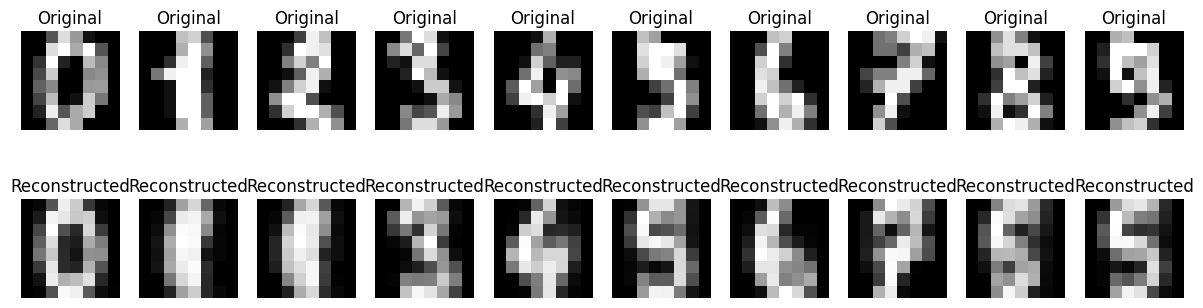

In [ ]:
# Plot original and reconstructed images
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

for i in range(num_images):
    # Original images
    axes[0, i].imshow(data[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images
    _, _, _, reconstructed_image = forward_pass(data[i:i+1])  # Run single image through forward pass
    axes[1, i].imshow(reconstructed_image.reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.show()


# Implementation of Autoencoders in PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:
# Load and scale dataset
digits = load_digits()
data = digits.data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert to PyTorch tensor
data = torch.tensor(data, dtype=torch.float32)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=32, bottleneck_dim=16):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use sigmoid to output values in [0, 1]
        )

    def forward(self, x):
        # Pass data through encoder, then decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
# Model, loss function, and optimizer
input_dim = data.shape[1]
model = Autoencoder(input_dim=input_dim, hidden_dim=32, bottleneck_dim=16)
criterion = nn.MSELoss()  # MSE for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
epochs = 1000
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    reconstructed = model(data)
    loss = criterion(reconstructed, data)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.18025480210781097
Epoch 100, Loss: 0.02986755780875683
Epoch 200, Loss: 0.021828897297382355
Epoch 300, Loss: 0.018895531073212624
Epoch 400, Loss: 0.016594363376498222
Epoch 500, Loss: 0.01548584271222353
Epoch 600, Loss: 0.014836321584880352
Epoch 700, Loss: 0.014151100069284439
Epoch 800, Loss: 0.013812550343573093
Epoch 900, Loss: 0.013597670011222363


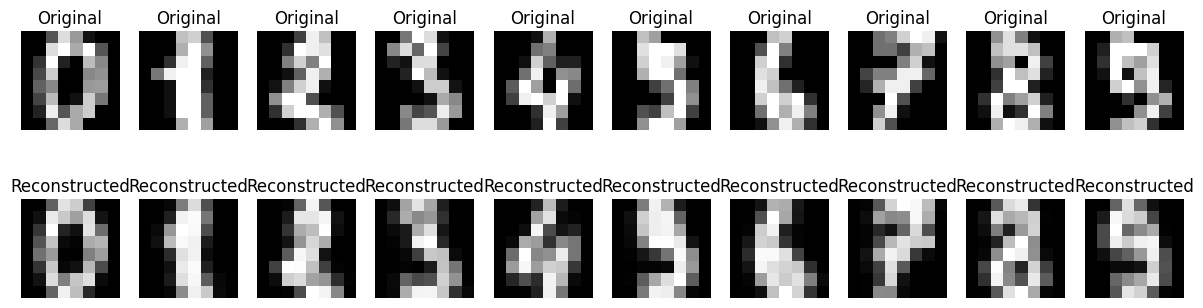

In [ ]:
# Plot original and reconstructed images
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

# Get reconstructed output
with torch.no_grad():
    reconstructed = model(data)

for i in range(num_images):
    # Original images
    axes[0, i].imshow(data[i].numpy().reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images
    axes[1, i].imshow(reconstructed[i].numpy().reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.show()


# Implementation of Variational Autoencoders in PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:
# Load and normalize dataset
digits = load_digits()
data = digits.data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = torch.tensor(data, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data, data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=32, latent_dim=16):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)        # For mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)    # For log variance

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)    # Convert log variance to standard deviation
        eps = torch.randn_like(std)      # Sample epsilon from standard normal
        return mu + eps * std            # Reparameterization trick

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)        # Encode input
        z = self.reparameterize(mu, logvar) # Sample z from latent space
        return self.decode(z), mu, logvar  # Decode and return reconstructed output


In [ ]:
def vae_loss(reconstructed, original, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum')

    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return recon_loss + kl_divergence


In [ ]:
# Set up model, optimizer
input_dim = data.shape[1]
model = VAE(input_dim=input_dim, hidden_dim=32, latent_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 50

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch, _ in dataloader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        reconstructed, mu, logvar = model(batch)

        # Compute loss and backpropagate
        loss = vae_loss(reconstructed, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        total_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 10.8326
Epoch 2, Loss: 8.9259
Epoch 3, Loss: 7.2613
Epoch 4, Loss: 6.3054
Epoch 5, Loss: 5.8008
Epoch 6, Loss: 5.4993
Epoch 7, Loss: 5.3136
Epoch 8, Loss: 5.1569
Epoch 9, Loss: 5.0667
Epoch 10, Loss: 4.9994
Epoch 11, Loss: 4.9752
Epoch 12, Loss: 4.9380
Epoch 13, Loss: 4.9180
Epoch 14, Loss: 4.8965
Epoch 15, Loss: 4.8833
Epoch 16, Loss: 4.8633
Epoch 17, Loss: 4.8645
Epoch 18, Loss: 4.8584
Epoch 19, Loss: 4.8480
Epoch 20, Loss: 4.8402
Epoch 21, Loss: 4.8278
Epoch 22, Loss: 4.8379
Epoch 23, Loss: 4.8386
Epoch 24, Loss: 4.8217
Epoch 25, Loss: 4.8192
Epoch 26, Loss: 4.8241
Epoch 27, Loss: 4.8125
Epoch 28, Loss: 4.8032
Epoch 29, Loss: 4.8178
Epoch 30, Loss: 4.8135
Epoch 31, Loss: 4.8012
Epoch 32, Loss: 4.8117
Epoch 33, Loss: 4.8032
Epoch 34, Loss: 4.7979
Epoch 35, Loss: 4.7986
Epoch 36, Loss: 4.7910
Epoch 37, Loss: 4.7940
Epoch 38, Loss: 4.7958
Epoch 39, Loss: 4.8030
Epoch 40, Loss: 4.7942
Epoch 41, Loss: 4.8026
Epoch 42, Loss: 4.7830
Epoch 43, Loss: 4.7906
Epoch 44, Loss: 4.7

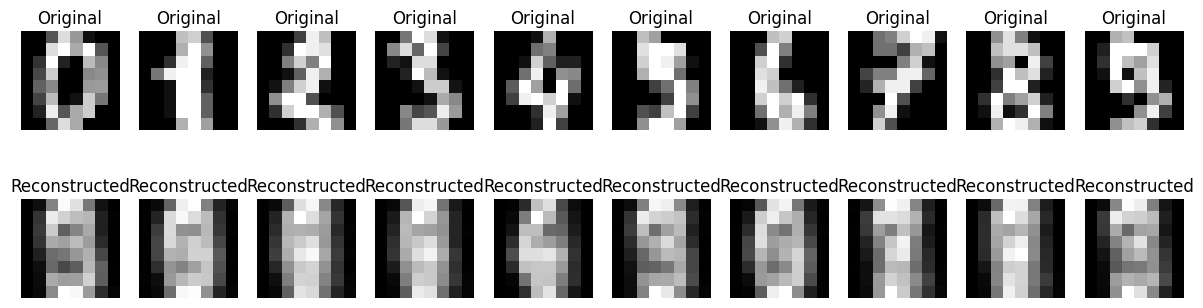

In [ ]:
# Plot original and reconstructed images
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient tracking for inference
    reconstructed, _, _ = model(data)

for i in range(num_images):
    # Original images
    axes[0, i].imshow(data[i].numpy().reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images
    axes[1, i].imshow(reconstructed[i].numpy().reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.show()
